This project conducts a systematic backtest of sentiment-driven trading strategies using the S&P 500 index and the CNN Fear & Greed Index from 2011-01-03 to 2023-12-29.

Objective: To evaluate whether dynamic allocation rules based on investor sentiment (buy when the market is fearful, sell when it is greedy) can outperform a passive Buy & Hold strategy.

Methodology:

Collected daily S&P 500 prices via yfinance and aligned them with the CNN Fear & Greed Index.

Designed multiple threshold-based strategies (e.g., full allocation when FG < 20, zero allocation when FG > 70, partial holding in between).

Implemented a backtesting engine that rebalances portfolio allocations daily, tracks equity curves, and calculates annualized percentage returns (APR).

Benchmarked results against a Buy & Hold S&P 500 portfolio.

Results: Produced comparative APR and equity curve visualizations, showing how sentiment-based strategies performed relative to the benchmark.

Tools: Python, yfinance, pandas, matplotlib, and NumPy.

This backtest highlights how sentiment indicators can be integrated into systematic strategies, while also demonstrating skills in data acquisition, time series alignment, portfolio simulation, and performance evaluation.

Backtest period: 2011-01-03 to 2023-12-29

APR Summary (2011-01-03 ~ 2023-12-29):
                    Final Value       APR
Strategy                                 
Buy&Hold_S&P500     3760.879741  0.107394
FG_<40_>90_hold90%  3480.051452  0.100795
FG_<30_>80_hold80%  2631.313961  0.077350
FG_<20_>70_hold70%  1882.725283  0.049931


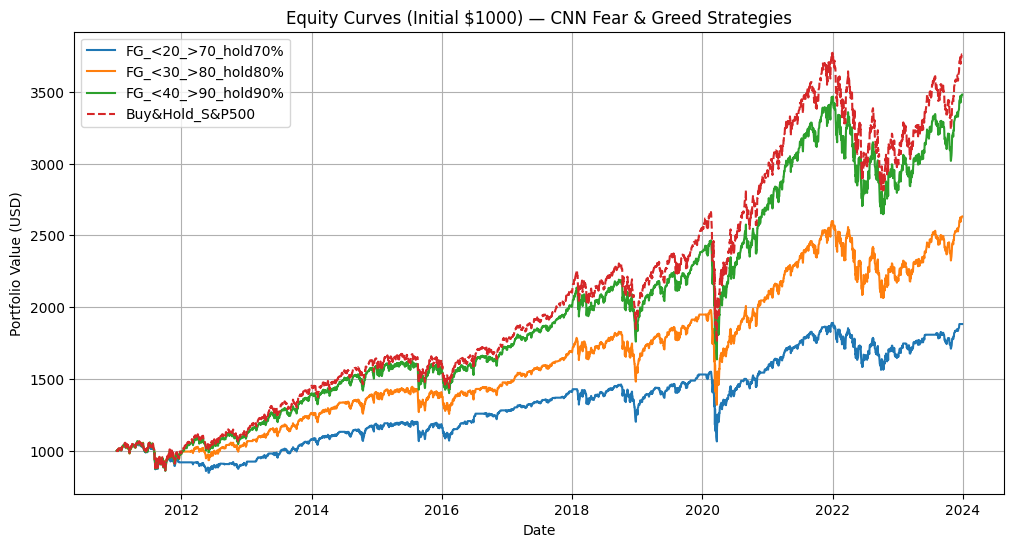

In [4]:
# 回测：使用 S&P500 + CNN Fear & Greed 指数
# 时间范围固定为 2011-01-03 到 2023-12-29

!pip install --quiet yfinance pandas matplotlib requests

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO

# --- 参数 ---
initial_equity = 1000.0
start_str = "2011-01-03"
end_str   = "2023-12-29"

print(f"Backtest period: {start_str} to {end_str}")
# --- 获取 S&P500 数据 ---
sp = yf.download("^GSPC", start=start_str, end=end_str, progress=False, auto_adjust=True)

# 如果是多层列，强制降维
if isinstance(sp.columns, pd.MultiIndex):
    sp.columns = sp.columns.droplevel(1)

# 保留收盘价
sp = sp[['Close']].rename(columns={'Close':'SP_Close'})
sp.index = pd.to_datetime(sp.index).normalize()
sp = sp.loc[~sp.index.duplicated()]   # 去掉可能重复日期

# --- 对齐到交易日 ---
all_days = pd.date_range(start=start_str, end=end_str, freq='B')
sp = sp.reindex(all_days).ffill()
# --- 获取 Fear & Greed 指数数据 ---
fg_csv_url = "https://raw.githubusercontent.com/whit3rabbit/fear-greed-data/main/fear-greed-2011-2023.csv"
resp = requests.get(fg_csv_url)
resp.raise_for_status()
fg = pd.read_csv(StringIO(resp.text))

# 列名是 Date 和 Fear Greed
fg['Date'] = pd.to_datetime(fg['Date']).dt.normalize()
fg = fg[['Date','Fear Greed']].rename(columns={'Fear Greed':'FG'})
fg = fg.sort_values('Date').drop_duplicates(subset='Date').set_index('Date')

fg = fg.reindex(all_days).ffill()

# 确保 index 都是普通 DatetimeIndex
sp.index = pd.to_datetime(sp.index)
fg.index = pd.to_datetime(fg.index)

# --- 合并 ---
data = pd.concat([sp, fg], axis=1, join="inner")
data = data.dropna(subset=['SP_Close','FG'])
data.head()
# --- 策略设定 ---
strategies = [
    {"name":"FG_<20_>70_hold70%", "buy_thresh":20, "sell_thresh":70, "hold_pct":0.70},
    {"name":"FG_<30_>80_hold80%", "buy_thresh":30, "sell_thresh":80, "hold_pct":0.80},
    {"name":"FG_<40_>90_hold90%", "buy_thresh":40, "sell_thresh":90, "hold_pct":0.90},
]

def run_strategy(df, buy_thresh, sell_thresh, hold_pct):
    cash = initial_equity
    sp_shares = 0.0
    equity_curve = []
    for date, row in df.iterrows():
        price = row['SP_Close']
        fg = row['FG']
        if fg < buy_thresh:
            target_alloc = 1.0
        elif fg > sell_thresh:
            target_alloc = 0.0
        else:
            target_alloc = hold_pct
        total_value = cash + sp_shares * price
        target_sp_value = total_value * target_alloc
        current_sp_value = sp_shares * price
        delta = target_sp_value - current_sp_value
        if abs(delta) > 1e-8:
            sp_shares += delta / price
            cash -= delta
        total_value = cash + sp_shares * price
        equity_curve.append({
            "Date":date,
            "Total":total_value,
            "Cash":cash,
            "SP_Value":sp_shares*price,
            "SP_Shares":sp_shares,
            "FG":fg
        })
    eq = pd.DataFrame(equity_curve).set_index('Date')
    return eq

# --- 回测所有策略 ---
results = {}
for s in strategies:
    eq = run_strategy(data[['SP_Close','FG']], s['buy_thresh'], s['sell_thresh'], s['hold_pct'])
    results[s['name']] = eq

# Buy & Hold baseline
first_price = data['SP_Close'].iloc[0]
bh_shares = initial_equity / first_price
bh_curve = pd.DataFrame(index=data.index)
bh_curve['Total'] = bh_shares * data['SP_Close']
bh_curve['Cash'] = 0.0
bh_curve['SP_Value'] = bh_curve['Total']
bh_curve['SP_Shares'] = bh_shares

# APR 计算函数
def compute_apr(series_total):
    start_val = series_total.iloc[0]
    end_val = series_total.iloc[-1]
    days = (series_total.index[-1] - series_total.index[0]).days
    years = days / 365.25
    if years <= 0:
        return np.nan
    apr = (end_val / start_val) ** (1.0/years) - 1.0
    return apr

# --- 输出结果 ---
summary = []
for name, eq in results.items():
    apr = compute_apr(eq['Total'])
    final = eq['Total'].iloc[-1]
    summary.append({"Strategy":name, "Final Value":final, "APR":apr})
bh_apr = compute_apr(bh_curve['Total'])
summary.append({"Strategy":"Buy&Hold_S&P500", "Final Value":bh_curve['Total'].iloc[-1], "APR":bh_apr})
summary_df = pd.DataFrame(summary).set_index('Strategy').sort_values('APR', ascending=False)

print("\nAPR Summary (2011-01-03 ~ 2023-12-29):")
print(summary_df.round(6))

# --- 绘图 ---
plt.figure(figsize=(12,6))
for name, eq in results.items():
    plt.plot(eq.index, eq['Total'], label=name)
plt.plot(bh_curve.index, bh_curve['Total'], linestyle='--', label='Buy&Hold_S&P500')
plt.title("Equity Curves (Initial $1000) — CNN Fear & Greed Strategies")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.grid(True)
plt.show()